# Advanced FITS Exploration + Scientific Visualization + Animation (GIF/MP4)

This notebook is a **drop-in replacement** workflow for exploring FITS images/cubes and producing **scientifically sensible** stills and **animations**.

## Techniques used (you’ll see these applied in cells)
1. **Header & axis introspection** (HDU info, shape, WCS keywords)
2. **Finite-value sanitization** (NaN/Inf handling)
3. **Sigma-clipping** (robust outlier rejection for hot pixels / cosmic rays)
4. **Background subtraction**
   - fast: **low-percentile background**
   - advanced (optional): **Photutils Background2D** (2D mesh background model)
5. **Robust display scaling**
   - **ZScale interval** (astronomy standard quicklook)
   - **Percentile intervals**
6. **Stretches** for dynamic range
   - **asinh** (excellent for galaxies/nebulae)
   - log / sqrt / linear
7. **WCSAxes** overlays (RA/Dec axes if WCS present)
8. **Image enhancement for analysis**
   - **Unsharp masking** (high-pass detail)
   - **Gradient magnitude / edges** (structure emphasis)
   - optional: **CLAHE** (contrast-limited adaptive histogram equalization)
9. **Cube analytics**
   - **Moment maps** (sum/mean over a cube axis)
10. **Animation best practices**
   - **Global normalization** to avoid brightness “pumping”
   - Optional downsampling for speed
11. **RGB composites**
   - **Lupton RGB** (asinh-based color composite used in astronomy)

---

> If your FITS is a *single 2D image*, there is no “plane axis” to animate—this notebook will automatically animate alternative views (different stretches) so you still get a useful GIF.



In [1]:
# -----------------------------
# Configuration
# -----------------------------
from pathlib import Path

FITS_PATH = Path("ngc6503.fits")   
OUT_DIR   = Path("outputs_advanced")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# Animation controls
FPS = 12                     # frames per second (GIF)
MAX_FRAMES = 200             # safety limit for huge cubes
DOWNSAMPLE = 1               # 1 = no downsample, 2 = half-res, 4 = quarter-res, ...
CMAP = "gray"                # "gray", "magma", "viridis", ...
NORM_MODE = "asinh"          # "asinh", "log", "sqrt", "linear"
INTERVAL_MODE = "zscale"     # "zscale" or "percentile"
PERCENTILE = 99.7            # used if INTERVAL_MODE="percentile"

print("FITS_PATH:", FITS_PATH.resolve())
print("OUT_DIR  :", OUT_DIR.resolve())


FITS_PATH: /home/hw1970218/Desktop/fits/ngc6503.fits
OUT_DIR  : /home/hw1970218/Desktop/fits/outputs_advanced


In [5]:
# -----------------------------
# Imports + optional dependencies
# -----------------------------
import os
import numpy as np
import matplotlib.pyplot as plt

from astropy.io import fits
from astropy.wcs import WCS
from astropy.stats import sigma_clip

from astropy.visualization import (
    ImageNormalize, AsinhStretch, LogStretch, SqrtStretch, LinearStretch,
    PercentileInterval, ZScaleInterval, make_lupton_rgb
)

# Optional: GIF writing
try:
    import imageio.v2 as imageio
    HAS_IMAGEIO = True
except Exception:
    HAS_IMAGEIO = False

# Optional: Pillow fallback for GIF
try:
    from PIL import Image
    HAS_PIL = True
except Exception:
    HAS_PIL = False

# Optional: Photutils (advanced background + detection)
try:
    import photutils
    from photutils.background import Background2D, MedianBackground
    HAS_PHOTUTILS = True
except Exception:
    HAS_PHOTUTILS = False

# Optional: Scipy for filtering
try:
    from scipy.ndimage import gaussian_filter, sobel
    HAS_SCIPY = True
except Exception:
    HAS_SCIPY = False

# Optional: skimage for CLAHE
try:
    from skimage import exposure
    HAS_SKIMAGE = True
except Exception:
    HAS_SKIMAGE = False

print("HAS_IMAGEIO :", HAS_IMAGEIO)
print("HAS_PIL     :", HAS_PIL)
print("HAS_PHOTUTILS:", HAS_PHOTUTILS)
print("HAS_SCIPY   :", HAS_SCIPY)
print("HAS_SKIMAGE :", HAS_SKIMAGE)

if not HAS_IMAGEIO and not HAS_PIL:
    print("⚠️ Neither imageio nor Pillow is available; GIF writing will be disabled.")


HAS_IMAGEIO : False
HAS_PIL     : True
HAS_PHOTUTILS: False
HAS_SCIPY   : True
HAS_SKIMAGE : False


In [7]:
# -----------------------------
# Load FITS + inspect HDUs
# -----------------------------
hdul = fits.open(FITS_PATH, memmap=False)
hdul.info()

# Choose which HDU contains the image/cube.
# Many survey FITS store data in extension 0 or 1.
HDU_INDEX = 0
data = hdul[HDU_INDEX].data
hdr  = hdul[HDU_INDEX].header

if data is None:
    raise ValueError("Selected HDU has no data. Try HDU_INDEX=1 (or another).")

print("\nData dtype:", np.asarray(data).dtype)
print("Data shape:", np.asarray(data).shape)
print("NAXIS:", hdr.get("NAXIS"))

# Helpful header preview (WCS-ish keys)
for k in ["OBJECT","TELESCOP","INSTRUME","FILTER","BUNIT","EXPTIME","DATE-OBS",
          "CTYPE1","CTYPE2","CTYPE3","CUNIT1","CUNIT2","CUNIT3","CRVAL1","CRVAL2","CRPIX1","CRPIX2"]:
    if k in hdr:
        print(f"{k:8s} = {hdr[k]}")


Filename: ngc6503.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     429   (256, 256, 31, 1)   float32   

Data dtype: >f4
Data shape: (1, 31, 256, 256)
NAXIS: 4
OBJECT   = NGC6503
TELESCOP = 
INSTRUME = 
BUNIT    = JY/BEAM
DATE-OBS = 12/04/83
CTYPE1   = RA---SIN
CTYPE2   = DEC--SIN
CTYPE3   = FELO-HEL
CRVAL1   = 267.490455508
CRVAL2   = 70.1571384072
CRPIX1   = 128.0
CRPIX2   = 129.0


In [8]:
# -----------------------------
# Helpers
# -----------------------------
def sanitize_finite(img: np.ndarray) -> np.ndarray:
    img = np.asarray(img, dtype=np.float64)
    finite = np.isfinite(img)
    fill = np.median(img[finite]) if finite.any() else 0.0
    return np.where(finite, img, fill)

def downsample2d(img: np.ndarray, factor: int) -> np.ndarray:
    if factor <= 1:
        return img
    # simple decimation (fast) — for analysis-quality, use rebin/average if you prefer
    return img[::factor, ::factor]

def detect_frame_axis(arr: np.ndarray) -> int | None:
    """Heuristic: choose a non-spatial axis to animate.
    Assumption: in standard FITS->numpy ordering, spatial axes are the LAST TWO.
    For ndim>=3, animate over the leading axis with the smallest 'reasonable' size.
    """
    arr = np.asarray(arr)
    if arr.ndim < 3:
        return None
    spatial = (-2, -1)
    candidate_axes = [ax for ax in range(arr.ndim) if ax not in [(arr.ndim-2), (arr.ndim-1)]]
    # pick the axis with size between 2 and MAX_FRAMES-ish and closest to typical cube depth
    sizes = [(ax, arr.shape[ax]) for ax in candidate_axes]
    # prefer smaller (but >1)
    sizes = [t for t in sizes if t[1] > 1]
    if not sizes:
        return None
    # choose smallest size (often spectral/time axis)
    sizes.sort(key=lambda t: t[1])
    return sizes[0][0]

def iter_frames(arr: np.ndarray, frame_axis: int) -> np.ndarray:
    """Yield 2D frames by iterating over frame_axis, keeping last two axes as Y,X."""
    arr = np.asarray(arr)
    # move frame axis to front
    arr2 = np.moveaxis(arr, frame_axis, 0)
    # now arr2 has shape (nframes, ..., ny, nx)
    ny, nx = arr2.shape[-2], arr2.shape[-1]
    arr2 = arr2.reshape(arr2.shape[0], -1, ny, nx)
    # if there are multiple 'extra' dims remaining, we take the first slice by default
    for i in range(arr2.shape[0]):
        yield arr2[i, 0]

def robust_background_subtract(img: np.ndarray, method: str = "percentile",
                               percentile: float = 20.0) -> tuple[np.ndarray, np.ndarray]:
    """Return (img_bgsub, bg_model)."""
    img = sanitize_finite(img)
    if method == "photutils" and HAS_PHOTUTILS:
        # Mesh size is a tradeoff; use something like 64 or 128 depending on image size
        box = (64, 64)
        filt = (3, 3)
        bkg = Background2D(img, box, filter_size=filt, bkg_estimator=MedianBackground())
        return img - bkg.background, bkg.background
    else:
        bg = np.percentile(img, percentile)
        return img - bg, np.full_like(img, bg, dtype=np.float64)

def preprocess(img: np.ndarray,
               do_sigma_clip: bool = True,
               clip_sigma: float = 3.5,
               clip_iters: int = 5,
               background: str = "percentile",   # "percentile" or "photutils"
               background_percentile: float = 20.0) -> tuple[np.ndarray, np.ndarray]:
    """Sanitize -> sigma-clip -> background subtract."""
    img = sanitize_finite(img)
    if do_sigma_clip:
        clipped = sigma_clip(img, sigma=clip_sigma, maxiters=clip_iters)
        if np.ma.isMaskedArray(clipped) and np.any(clipped.mask):
            med = np.ma.median(clipped)
            img = clipped.filled(float(med))
        else:
            img = np.asarray(clipped)
    img_bgsub, bg_model = robust_background_subtract(img, method=background, percentile=background_percentile)
    return img_bgsub, bg_model

def make_norm(img: np.ndarray, interval_mode: str = "zscale",
              p: float = 99.7, stretch_mode: str = "asinh") -> ImageNormalize:
    if interval_mode == "zscale":
        interval = ZScaleInterval()
    else:
        interval = PercentileInterval(p)
    stretch = {
        "asinh": AsinhStretch(),
        "log": LogStretch(),
        "sqrt": SqrtStretch(),
        "linear": LinearStretch(),
    }.get(stretch_mode, AsinhStretch())
    return ImageNormalize(img, interval=interval, stretch=stretch)

def to_uint8_gray(img: np.ndarray, norm: ImageNormalize) -> np.ndarray:
    x = norm(img)
    x = np.clip(x, 0.0, 1.0)
    return (x * 255).astype(np.uint8)

def apply_cmap_uint8(gray_u8: np.ndarray, cmap: str = "gray") -> np.ndarray:
    # Map grayscale uint8 -> RGB uint8 using matplotlib colormap
    cm = plt.get_cmap(cmap)
    rgb = (cm(gray_u8 / 255.0)[:, :, :3] * 255).astype(np.uint8)
    return rgb

def unsharp_mask(img: np.ndarray, sigma: float = 2.0, strength: float = 1.0) -> np.ndarray:
    if not HAS_SCIPY:
        raise RuntimeError("scipy is required for unsharp masking")
    blur = gaussian_filter(img, sigma=sigma)
    high = img - blur
    return img + strength * high

def gradient_magnitude(img: np.ndarray) -> np.ndarray:
    if not HAS_SCIPY:
        raise RuntimeError("scipy is required for gradients")
    gx = sobel(img, axis=1)
    gy = sobel(img, axis=0)
    return np.hypot(gx, gy)

def clahe(img: np.ndarray, clip_limit: float = 0.01) -> np.ndarray:
    if not HAS_SKIMAGE:
        raise RuntimeError("skimage is required for CLAHE")
    # Normalize to 0..1 for CLAHE
    vmin, vmax = np.percentile(img, [1, 99])
    x = np.clip((img - vmin) / (vmax - vmin + 1e-12), 0, 1)
    return exposure.equalize_adapthist(x, clip_limit=clip_limit)

print("Helpers ready.")


Helpers ready.


In [11]:
# -----------------------------
# Identify whether this is 2D or a cube, and choose an animation axis
# -----------------------------
arr = np.asarray(data)
print("ndim:", arr.ndim, "shape:", arr.shape)

frame_axis = detect_frame_axis(arr)
if frame_axis is None:
    print("This looks like a single 2D image (or no clear frame axis).")
else:
    print("Detected frame_axis =", frame_axis, "size =", arr.shape[frame_axis])

# Pull one representative 2D frame for quicklook:
if arr.ndim == 2:
    frame0 = arr
else:
    frame0 = next(iter_frames(arr, frame_axis))

frame0 = downsample2d(frame0, DOWNSAMPLE)
img0, bg0 = preprocess(frame0, do_sigma_clip=True,
                       background=("photutils" if HAS_PHOTUTILS else "percentile"))

print("Frame0 stats after preprocess:",
      "min", float(np.min(img0)), "max", float(np.max(img0)),
      "median", float(np.median(img0)))


ndim: 4 shape: (1, 31, 256, 256)
Detected frame_axis = 1 size = 31
Frame0 stats after preprocess: min -2.929700646054062e+31 max 3.245567487630031e+32 median 1.1868054994302305e+29


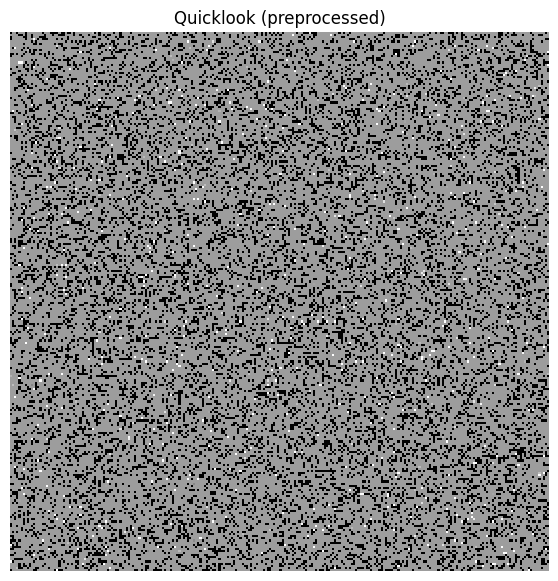

Saved: outputs_advanced/quicklook.png


In [12]:
# -----------------------------
# Quicklook visualization: ZScale / Percentile + chosen stretch
# -----------------------------
norm = make_norm(img0, interval_mode=INTERVAL_MODE, p=PERCENTILE, stretch_mode=NORM_MODE)

plt.figure(figsize=(7, 7))
plt.imshow(img0, origin="lower", cmap=CMAP, norm=norm, interpolation="nearest")
plt.title("Quicklook (preprocessed)")
plt.axis("off")
plt.show()

# Save a publication-friendly PNG
out_png = OUT_DIR / "quicklook.png"
plt.figure(figsize=(7, 7), dpi=250)
plt.imshow(img0, origin="lower", cmap=CMAP, norm=norm, interpolation="nearest")
plt.axis("off")
plt.tight_layout(pad=0)
plt.savefig(out_png, bbox_inches="tight", pad_inches=0)
plt.close()
print("Saved:", out_png)


In [13]:
# -----------------------------
# WCS plot (RA/Dec axes) if WCS is present
# -----------------------------
wcs = None
try:
    wcs = WCS(hdr)
    # WCS can exist but be non-celestial; check if it has celestial component
    celestial = wcs.celestial
    has_celestial = celestial is not None and celestial.pixel_n_dim >= 2
except Exception:
    has_celestial = False

print("WCS present:", wcs is not None, "Has celestial:", has_celestial)

if has_celestial:
    fig = plt.figure(figsize=(8, 7))
    ax = fig.add_subplot(111, projection=celestial)
    ax.imshow(img0, origin="lower", cmap=CMAP, norm=norm, interpolation="nearest")
    ax.set_xlabel("RA")
    ax.set_ylabel("Dec")
    ax.grid(color="white", ls=":", alpha=0.35)
    plt.title("WCSAxes quicklook (celestial)")
    plt.show()
else:
    print("No usable celestial WCS detected; skipping WCSAxes plot.")


WCS present: False Has celestial: False
No usable celestial WCS detected; skipping WCSAxes plot.


Changed DATE-OBS from '12/04/83' to '1983-04-12''. [astropy.wcs.wcs]


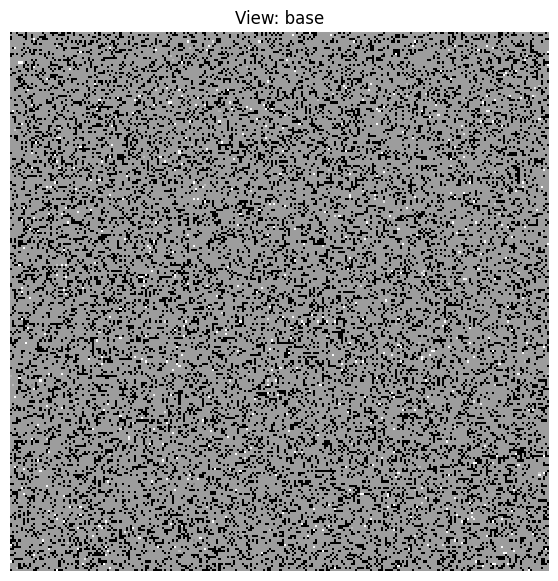

Saved: outputs_advanced/view_base.png


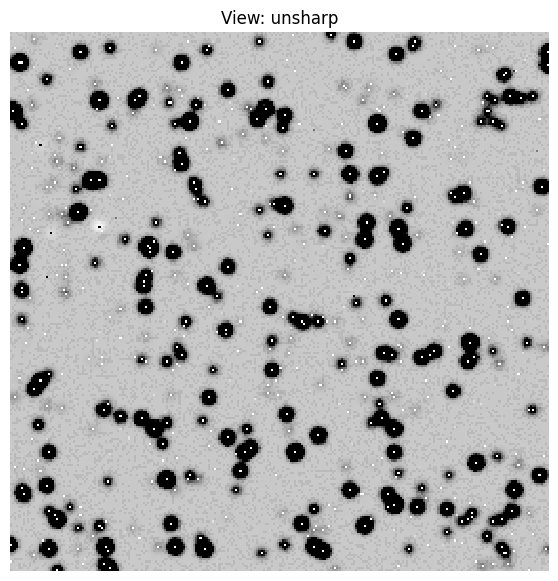

Saved: outputs_advanced/view_unsharp.png


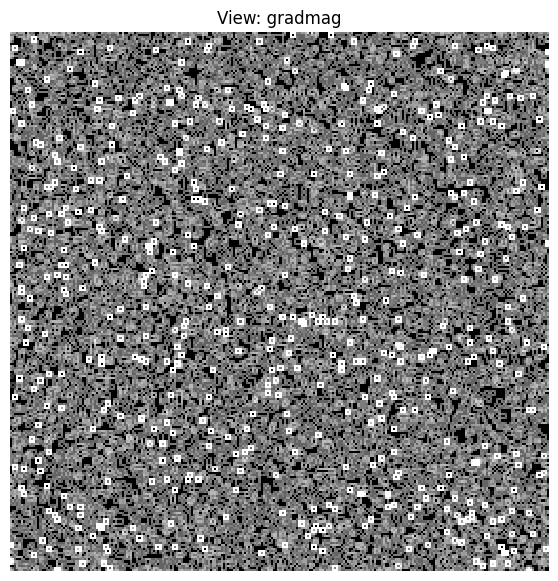

Saved: outputs_advanced/view_gradmag.png


In [8]:
# -----------------------------
# Advanced enhancement views (analysis aids)
#   - Unsharp masking (detail)
#   - Gradient magnitude (edges / structure)
#   - Optional CLAHE
# -----------------------------
views = {}

# Base view
views["base"] = img0

if HAS_SCIPY:
    views["unsharp"] = unsharp_mask(img0, sigma=2.0, strength=1.2)
    views["gradmag"] = gradient_magnitude(img0)

if HAS_SKIMAGE:
    # CLAHE returns 0..1 — scale back to roughly image-like for display
    views["clahe"] = clahe(img0, clip_limit=0.01)

for name, v in views.items():
    plt.figure(figsize=(7, 7))
    if name == "clahe":
        plt.imshow(v, origin="lower", cmap=CMAP, interpolation="nearest")
    else:
        n = make_norm(v, interval_mode=INTERVAL_MODE, p=PERCENTILE, stretch_mode=NORM_MODE)
        plt.imshow(v, origin="lower", cmap=CMAP, norm=n, interpolation="nearest")
    plt.title(f"View: {name}")
    plt.axis("off")
    plt.show()

    # Save each view
    out = OUT_DIR / f"view_{name}.png"
    plt.figure(figsize=(7, 7), dpi=250)
    if name == "clahe":
        plt.imshow(v, origin="lower", cmap=CMAP, interpolation="nearest")
    else:
        plt.imshow(v, origin="lower", cmap=CMAP, norm=n, interpolation="nearest")
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.savefig(out, bbox_inches="tight", pad_inches=0)
    plt.close()
    print("Saved:", out)


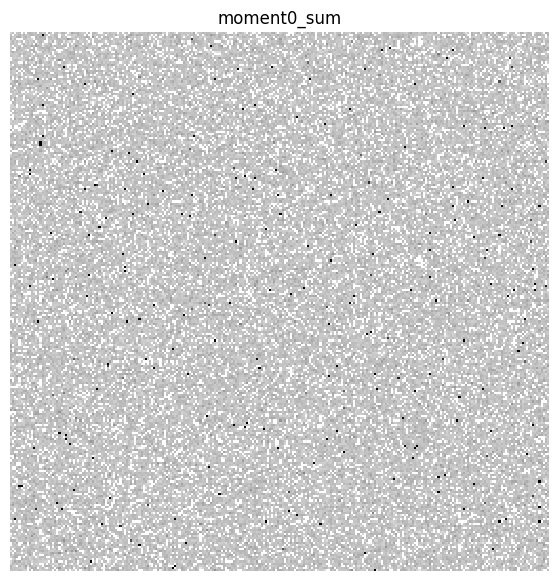

Saved: outputs_advanced/moment0_sum.png


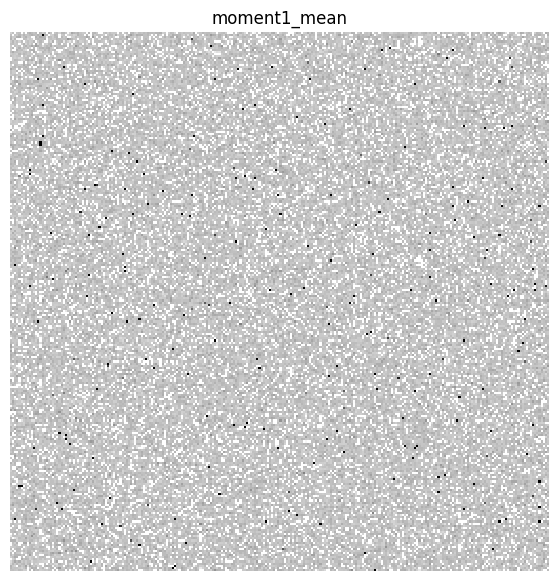

Saved: outputs_advanced/moment1_mean.png


In [14]:
# -----------------------------
# Cube analytics: moment maps (if cube)
# -----------------------------
arr = np.asarray(data)

if arr.ndim >= 3 and frame_axis is not None:
    # interpret animation axis as a "spectral/time" axis; compute moment maps along it
    arr_moved = np.moveaxis(arr, frame_axis, 0)
    # Take first slice across any remaining non-spatial dims:
    ny, nx = arr_moved.shape[-2], arr_moved.shape[-1]
    arr_moved = arr_moved.reshape(arr_moved.shape[0], -1, ny, nx)[:, 0]
    arr_moved = np.asarray([downsample2d(f, DOWNSAMPLE) for f in arr_moved])

    # preprocess each frame lightly (no background subtraction yet) to avoid biasing moments too much
    proc_frames = []
    for i, f in enumerate(arr_moved[:MAX_FRAMES]):
        f2, _ = preprocess(f, do_sigma_clip=True, background=("photutils" if HAS_PHOTUTILS else "percentile"))
        proc_frames.append(f2)
    proc_frames = np.stack(proc_frames, axis=0)

    moment0 = np.sum(proc_frames, axis=0)
    moment1 = np.mean(proc_frames, axis=0)

    for name, img in [("moment0_sum", moment0), ("moment1_mean", moment1)]:
        n = make_norm(img, interval_mode=INTERVAL_MODE, p=PERCENTILE, stretch_mode=NORM_MODE)
        plt.figure(figsize=(7,7))
        plt.imshow(img, origin="lower", cmap=CMAP, norm=n, interpolation="nearest")
        plt.title(name)
        plt.axis("off")
        plt.show()

        out = OUT_DIR / f"{name}.png"
        plt.figure(figsize=(7,7), dpi=250)
        plt.imshow(img, origin="lower", cmap=CMAP, norm=n, interpolation="nearest")
        plt.axis("off")
        plt.tight_layout(pad=0)
        plt.savefig(out, bbox_inches="tight", pad_inches=0)
        plt.close()
        print("Saved:", out)
else:
    print("Not a cube (or no clear frame axis); skipping moment maps.")


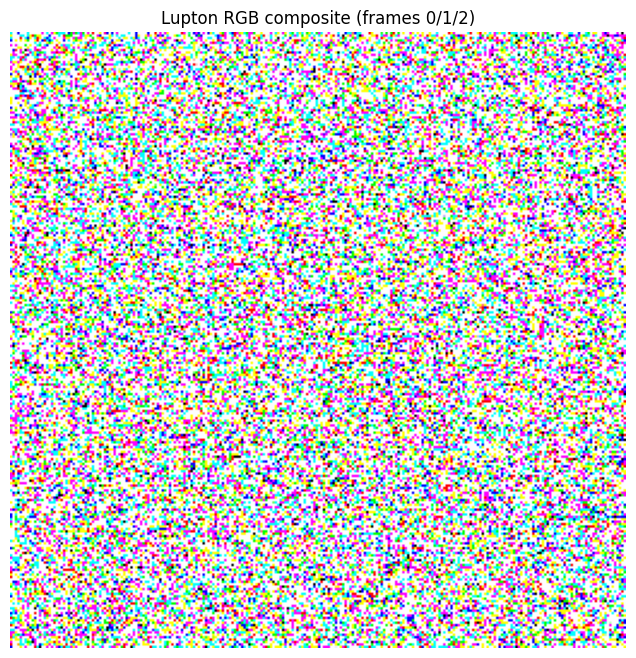

Saved: outputs_advanced/lupton_rgb.png


In [10]:
# -----------------------------
# RGB composite (Lupton RGB) if you have 3 meaningful frames/bands
# -----------------------------
arr = np.asarray(data)

def get_nth_frame(n: int) -> np.ndarray:
    if arr.ndim == 2:
        return arr
    frames = list(iter_frames(arr, frame_axis))
    if n >= len(frames):
        n = len(frames) - 1
    return frames[n]

if arr.ndim >= 3 and frame_axis is not None and arr.shape[frame_axis] >= 3:
    r = downsample2d(get_nth_frame(0), DOWNSAMPLE)
    g = downsample2d(get_nth_frame(1), DOWNSAMPLE)
    b = downsample2d(get_nth_frame(2), DOWNSAMPLE)

    r, _ = preprocess(r, background=("photutils" if HAS_PHOTUTILS else "percentile"))
    g, _ = preprocess(g, background=("photutils" if HAS_PHOTUTILS else "percentile"))
    b, _ = preprocess(b, background=("photutils" if HAS_PHOTUTILS else "percentile"))

    # Lupton RGB: astronomy-standard asinh color composite
    rgb = make_lupton_rgb(r, g, b, Q=10, stretch=0.5)  # tweak Q/stretch for taste/science

    plt.figure(figsize=(8, 8))
    plt.imshow(rgb, origin="lower")
    plt.title("Lupton RGB composite (frames 0/1/2)")
    plt.axis("off")
    plt.show()

    out = OUT_DIR / "lupton_rgb.png"
    plt.imsave(out, rgb)
    print("Saved:", out)
else:
    print("Not enough frames/bands for RGB composite; skipping.")


Prepared cube frames: 31
Saved GIF: outputs_advanced/animation.gif


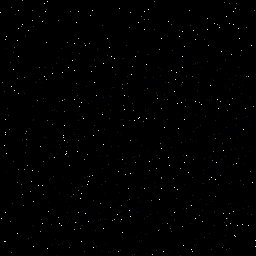

In [15]:
# -----------------------------
# Animation / GIF
# - If cube: animate through frames along frame_axis
# - If 2D only: animate different display stretches (still useful!)
# -----------------------------
def write_gif(frames_rgb: list[np.ndarray], out_path: Path, fps: float = 12.0):
    duration_ms = int(1000.0 / fps)
    if HAS_IMAGEIO:
        imageio.mimsave(out_path, frames_rgb, duration=1.0/fps)
        return
    if HAS_PIL:
        pil_frames = [Image.fromarray(f) for f in frames_rgb]
        pil_frames[0].save(out_path, save_all=True, append_images=pil_frames[1:],
                           duration=duration_ms, loop=0, optimize=False)
        return
    raise RuntimeError("No GIF writer available (need imageio or Pillow).")

arr = np.asarray(data)
frames_rgb = []

if arr.ndim >= 3 and frame_axis is not None:
    # Build frames from cube, with GLOBAL normalization (avoids brightness pumping).
    raw_frames = []
    for i, f in enumerate(iter_frames(arr, frame_axis)):
        if i >= MAX_FRAMES:
            break
        f = downsample2d(f, DOWNSAMPLE)
        f, _ = preprocess(f, do_sigma_clip=True, background=("photutils" if HAS_PHOTUTILS else "percentile"))
        raw_frames.append(f)
    raw_frames = np.stack(raw_frames, axis=0)

    # Estimate global norm from a random sample of pixels (memory-friendly)
    flat = raw_frames.reshape(raw_frames.shape[0], -1)
    sample_n = min(flat.size, 1_000_000)
    idx = np.random.choice(flat.size, size=sample_n, replace=False)
    sample = flat.reshape(-1)[idx]
    sample = sample[np.isfinite(sample)]
    if INTERVAL_MODE == "zscale":
        # zscale on a sample: approximate by percentile bounds for stability
        vmin, vmax = np.percentile(sample, [1, 99.7])
        interval = PercentileInterval(99.7)
        # We'll feed norm with a representative frame but clip via percentiles
        global_norm = make_norm(raw_frames[0], interval_mode="percentile", p=99.7, stretch_mode=NORM_MODE)
    else:
        global_norm = make_norm(raw_frames[0], interval_mode="percentile", p=PERCENTILE, stretch_mode=NORM_MODE)

    for f in raw_frames:
        gray = to_uint8_gray(f, global_norm)
        rgb = apply_cmap_uint8(gray, cmap=CMAP)
        frames_rgb.append(rgb)

    print("Prepared cube frames:", len(frames_rgb))

else:
    # 2D image: animate a set of analytical looks (stretches + enhancement)
    base = downsample2d(arr, DOWNSAMPLE)
    base, _ = preprocess(base, do_sigma_clip=True, background=("photutils" if HAS_PHOTUTILS else "percentile"))

    stretch_list = ["linear", "sqrt", "log", "asinh"]
    for sm in stretch_list:
        n = make_norm(base, interval_mode=INTERVAL_MODE, p=PERCENTILE, stretch_mode=sm)
        gray = to_uint8_gray(base, n)
        frames_rgb.append(apply_cmap_uint8(gray, cmap=CMAP))

    if HAS_SCIPY:
        u = unsharp_mask(base, sigma=2.0, strength=1.2)
        n = make_norm(u, interval_mode=INTERVAL_MODE, p=PERCENTILE, stretch_mode="asinh")
        frames_rgb.append(apply_cmap_uint8(to_uint8_gray(u, n), cmap=CMAP))

        g = gradient_magnitude(base)
        n = make_norm(g, interval_mode="percentile", p=99.7, stretch_mode="sqrt")
        frames_rgb.append(apply_cmap_uint8(to_uint8_gray(g, n), cmap=CMAP))

    if HAS_SKIMAGE:
        c = clahe(base, clip_limit=0.01)
        # already 0..1
        frames_rgb.append((np.dstack([c, c, c]) * 255).astype(np.uint8))

    print("Prepared analytical frames (2D image):", len(frames_rgb))

# Write GIF
gif_path = OUT_DIR / "animation.gif"
write_gif(frames_rgb, gif_path, fps=FPS)
print("Saved GIF:", gif_path)

# Display in notebook
from IPython.display import Image as IPyImage, display
display(IPyImage(filename=str(gif_path)))


In [16]:
# -----------------------------
# Clean up
# -----------------------------
hdul.close()
print("Done. Outputs are in:", OUT_DIR.resolve())


Done. Outputs are in: /home/hw1970218/Desktop/fits/outputs_advanced
